Camera Matrix:
 [[540.46034318   0.         324.22665147]
 [  0.         397.57255883 210.38912271]
 [  0.           0.           1.        ]]
Reproj Error (pixels): 0.3979
[[592.46807458   0.         319.10665444]
 [  0.         431.98109312 204.48077184]
 [  0.           0.           1.        ]]


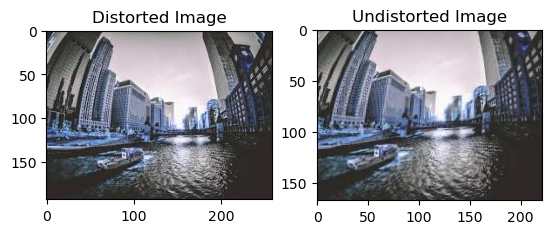

In [21]:
import numpy as np
import cv2 as cv
import glob
import os 
import matplotlib.pyplot as plt
from sympy import im 

def calibrate(showPics=True):
    # Read Image
    root = os.getcwd()
    calibrationDir = os.path.join(root,'output','images')
    imgPathList = glob.glob(os.path.join(calibrationDir,'*.png'))

    # Initialize  
    nRows = 7 
    nCols = 7 
    termCriteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER,30,0.001)
    worldPtsCur = np.zeros((nRows*nCols,3), np.float32)
    worldPtsCur[:,:2] = np.mgrid[0:nRows,0:nCols].T.reshape(-1,2)
    worldPtsCur *= 20
    #print(worldPtsCur)
    worldPtsList = []
    imgPtsList = [] 
    imgGray = None
    # Find Corners 
    for curImgPath in imgPathList:
        imgBGR = cv.imread(curImgPath)
        imgGray = cv.cvtColor(imgBGR, cv.COLOR_BGR2GRAY)
        cornersFound, cornersOrg = cv.findChessboardCorners(imgGray,(nRows,nCols), None)

        if cornersFound == True:
            worldPtsList.append(worldPtsCur)
            cornersRefined = cv.cornerSubPix(imgGray,cornersOrg,(11,11),(-1,-1),termCriteria)
            imgPtsList.append(cornersRefined)

            if showPics: 
                cv.drawChessboardCorners(imgBGR,(nRows,nCols),cornersRefined,cornersFound)
                cv.imshow('Chessboard', imgBGR)
                cv.waitKey(500)
                cv.destroyAllWindows()

    
    # Calibrate 
    repError,camMatrix,distCoeff,rvecs,tvecs = cv.calibrateCamera(worldPtsList, imgPtsList, imgGray.shape[::-1],None,None)
    print('Camera Matrix:\n',camMatrix)
    print("Reproj Error (pixels): {:.4f}".format(repError))
    
    # Save Calibration Parameters (later video)
    #curFolder = os.path.dirname(os.path.abspath(__file__))
    curFolder = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
    paramPath = os.path.join(curFolder,'output','calib_data','calibratioon.npz')
    np.savez(paramPath, 
        repError=repError, 
        camMatrix=camMatrix, 
        distCoeff=distCoeff, 
        rvecs=rvecs, 
        tvecs=tvecs)
    
    return camMatrix,distCoeff

def removeDistortion(camMatrix,distCoeff): 
    root = os.getcwd()
    imgPath = os.path.join(root,'data','undistortion.jpg')
    img = cv.imread(imgPath)
    
    height,width = img.shape[:2]
    camMatrixNew,roi = cv.getOptimalNewCameraMatrix(camMatrix,distCoeff,(width,height),1,(width,height)) # function helps optimize the camera matrix
    print(camMatrixNew)
    imgUndist = cv.undistort(img,camMatrix,distCoeff,None,camMatrixNew)
    x, y, w, h = roi
    imgUndistCropped = imgUndist[y:y+h, x:x+w]
    

    # Draw Line to See Distortion Change 
    cv.line(img,(1769,103),(1780,922),(255,255,255),2)
    cv.line(imgUndist,(1769,103),(1780,922),(255,255,255),2)

    plt.figure() 
    plt.subplot(121)
    plt.imshow(img)
    plt.title('Distorted Image')
    # plt.subplot(122)
    # plt.imshow(imgUndist)
    # plt.title('Undistorted Image')
    plt.subplot(122)
    plt.imshow(imgUndistCropped)
    plt.title('Undistorted Image')
    plt.show()

def runCalibration(): 
    calibrate(showPics=True) 

def runRemoveDistortion(): 
    camMatrix,distCoeff = calibrate(showPics=False) 
    removeDistortion(camMatrix,distCoeff) 

if __name__ == '__main__': 
    #runCalibration() 
    runRemoveDistortion()